In [18]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [19]:
# Parameters
n, p = 100, 1000
block_size, rho = 50, 0.6
n_informative = 50
rng = np.random.default_rng(42)

# Block correlation matrix
block = rho * np.ones((block_size, block_size)) + (1 - rho) * np.eye(block_size)
Sigma = np.kron(np.eye(p // block_size), block)

# Simulate Gaussian features
X = rng.multivariate_normal(mean=np.zeros(p), cov=Sigma, size=n)

# Plant informative features (first 50)
beta = np.zeros(p)
beta[:n_informative] = rng.choice([-1, 1], size=n_informative)
y_prob = 1 / (1 + np.exp(-X @ beta / np.sqrt(n_informative)))
y = rng.binomial(1, y_prob)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


In [20]:
def fair_screening(X, y, d):
    """Select top-d features by absolute correlation with label"""
    corrs = np.array([np.corrcoef(X[:, j], y)[0, 1] for j in range(X.shape[1])])
    corrs = np.nan_to_num(corrs)  # handle NaNs
    top_idx = np.argsort(-np.abs(corrs))[:d]
    return top_idx, corrs


In [21]:
def train_fair_lda(X_train, y_train, X_test, top_idx):
    lda = LinearDiscriminantAnalysis(solver="svd")
    lda.fit(X_train[:, top_idx], y_train)
    return accuracy_score(y_test, lda.predict(X_test[:, top_idx]))

def train_diag_lda(X_train, y_train, X_test, top_idx):
    lda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")
    lda.fit(X_train[:, top_idx], y_train)
    return accuracy_score(y_test, lda.predict(X_test[:, top_idx]))

def train_logistic(X_train, y_train, X_test, top_idx):
    clf = LogisticRegression(penalty="l1", solver="saga", max_iter=5000, C=0.1)
    clf.fit(X_train[:, top_idx], y_train)
    return accuracy_score(y_test, clf.predict(X_test[:, top_idx]))


In [22]:
d_values = range(5, 55, 5)
acc_results = {"FAIR+LDA": [], "DiagLDA": [], "LogisticL1": []}
screening_scores = None  # store correlations for visualization

for d in d_values:
    top_idx, corrs = fair_screening(X_train, y_train, d)
    if d == 20:  # save screening scores for visualization
        screening_scores = (corrs, top_idx)

    acc_results["FAIR+LDA"].append(train_fair_lda(X_train, y_train, X_test, top_idx))
    acc_results["DiagLDA"].append(train_diag_lda(X_train, y_train, X_test, top_idx))
    acc_results["LogisticL1"].append(train_logistic(X_train, y_train, X_test, top_idx))


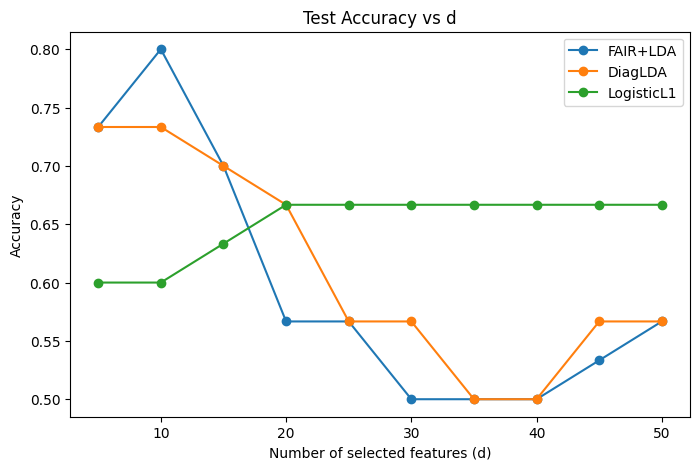

In [23]:
plt.figure(figsize=(8,5))
for method, accs in acc_results.items():
    plt.plot(d_values, accs, marker="o", label=method)
plt.xlabel("Number of selected features (d)")
plt.ylabel("Accuracy")
plt.title("Test Accuracy vs d")
plt.legend()
plt.show()


In [24]:
ds = list(range(5, 55, 5))
results = {"d": [], "method": [], "acc": []}

for d in ds:
    idx, corrs = fair_screening(X_train, y_train, d)
    Xtr, Xte = X_train[:, idx], X_test[:, idx]

    # FAIR + LDA (svd)
    lda = LinearDiscriminantAnalysis(solver="svd")
    lda.fit(Xtr, y_train)
    acc_lda = accuracy_score(y_test, lda.predict(Xte))
    results["d"].append(d); results["method"].append("FAIR+LDA"); results["acc"].append(acc_lda)

    # Diagonal-ish LDA (lsqr with shrinkage)
    lda2 = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")
    lda2.fit(Xtr, y_train)
    acc_diag = accuracy_score(y_test, lda2.predict(Xte))
    results["d"].append(d); results["method"].append("DiagLDA"); results["acc"].append(acc_diag)

    # Logistic L1
    logit = LogisticRegression(penalty="l1", solver="saga", max_iter=5000)
    logit.fit(Xtr, y_train)
    acc_logit = accuracy_score(y_test, logit.predict(Xte))
    results["d"].append(d); results["method"].append("Logit-L1"); results["acc"].append(acc_logit)

results_df = pd.DataFrame(results)
summary = results_df.groupby("method").apply(
    lambda df: df.loc[df["acc"].idxmax(), ["d","acc"]]
).reset_index()

summary.columns = ["Method", "Best_d", "Max_Test_Accuracy"]
print(summary)

     Method  Best_d  Max_Test_Accuracy
0   DiagLDA       5           0.733333
1  FAIR+LDA      10           0.800000
2  Logit-L1      10           0.766667


/tmp/ipython-input-361818387.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = results_df.groupby("method").apply(


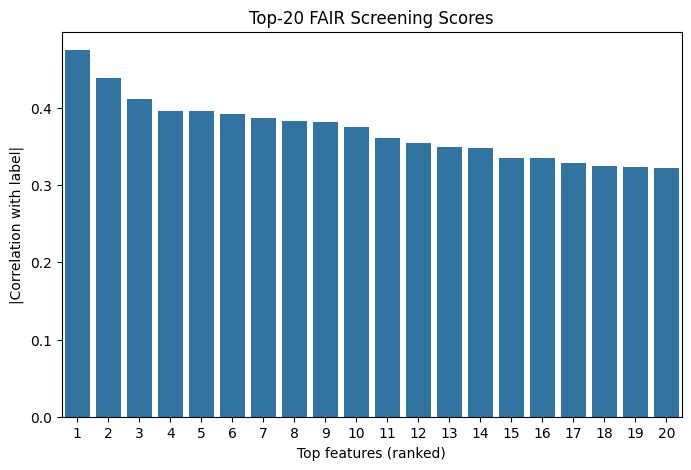

In [25]:
corrs, _ = screening_scores
top20_idx = np.argsort(-np.abs(corrs))[:20]
plt.figure(figsize=(8,5))
sns.barplot(x=np.arange(1,21), y=np.abs(corrs[top20_idx]))
plt.xlabel("Top features (ranked)")
plt.ylabel("|Correlation with label|")
plt.title("Top-20 FAIR Screening Scores")
plt.show()


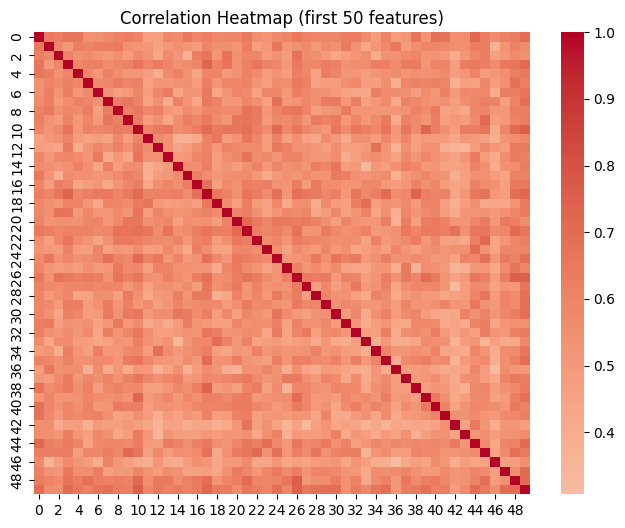

In [26]:
plt.figure(figsize=(8,6))
sns.heatmap(np.corrcoef(X_train[:, :50].T), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (first 50 features)")
plt.show()
